In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, mean_squared_error, accuracy_score, roc_auc_score, mean_absolute_error
import sklearn.model_selection
from typing import Tuple, List, Any, Dict, Union
from xgboost import XGBRegressor
import optuna
import pickle

SEED = 17
compare_metric_name = 'RMSE'

## Utils

In [ ]:
def read_table_from_db(table_name):
    df = pd.read_sql(f'SELECT * FROM {table_name}', con=DB)
    return df

In [2]:
def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: Any, cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: sklearn.metrics = root_mean_squared_error) -> Tuple[List[float], List[float]]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (Any): algorithm to use for training and prediction
        cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=SEED)): cross-validation strategy
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
    
    Returns:
        Tuple[List[float], List[float]]: Tuple of lists of train and validation scores
    """
    train_scores, validation_scores = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        train_scores.append(metric(y_train, y_train_pred))
        validation_scores.append(metric(y_val, y_val_pred))
    return train_scores, validation_scores

def evaluation(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: Any, metric: sklearn.metrics = root_mean_squared_error) -> Tuple[float, float, np.ndarray]:
    """
    Train the algorithm on the train data and evaluate on the train and test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (Any): algorithm to use for training and prediction
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
    
    Returns:
        Tuple[float, float, np.ndarray]: train_score, test_score, predictions on test data
    """
    algorithm.fit(X_train, y_train)
    y_train_pred = algorithm.predict(X_train)
    y_test_pred = algorithm.predict(X_test)
    train_results = metric(y_train, y_train_pred)
    test_results = metric(y_test, y_test_pred)
    return train_results, test_results, y_test_pred

# Load dataset

In [ ]:
data = read_table_from_db('airbnb_data')
target_feature = 'log_price'
independent_features = data.columns.drop(target_feature)
data.head()

## Split dataset

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

In [5]:
del data

## Base model

In [6]:
model = XGBRegressor(random_state=SEED, n_jobs=-1)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train RMSE: 0.2598 +- 0.0024
Validation RMSE: 0.3942 +- 0.0037


# Hyperparameter optimization

In this section, we will optimize the hyperparameters of the XGBRegressor.

## `max_depth`

`max_depth` - Maximum depth of a tree, in other words: the length of the longest path from a root to a leaf.

Higher values will make the model more complex and more likely to overfit.

In [6]:
for max_depth in range(2, 10):
    model = XGBRegressor(max_depth=max_depth, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Max depth: {}; Train {}: {:.4f}; Validation {}: {:.4f}".format(max_depth, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Max depth: 2; Train RMSE: 0.4192; Validation RMSE: 0.4296
Max depth: 3; Train RMSE: 0.3811; Validation RMSE: 0.4077
Max depth: 4; Train RMSE: 0.3451; Validation RMSE: 0.3996
Max depth: 5; Train RMSE: 0.3047; Validation RMSE: 0.3954
Max depth: 6; Train RMSE: 0.2598; Validation RMSE: 0.3942
Max depth: 7; Train RMSE: 0.2077; Validation RMSE: 0.3947
Max depth: 8; Train RMSE: 0.1598; Validation RMSE: 0.3971
Max depth: 9; Train RMSE: 0.1110; Validation RMSE: 0.3993


We have obtained best validation results for max_depth = 7.

In [7]:
best_max_depth = 7

## `n_estimators`

`n_estimators` - The number of trees in the forest.

The more trees we have, the better the model will generalize.

In [8]:
for n_estimators in range(50, 500, 50):
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=n_estimators, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("n_estimators: {}; Train {}: {:.4f}; Validation {}: {:.4f}".format(n_estimators, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

n_estimators: 50; Train RMSE: 0.2700; Validation RMSE: 0.3957
n_estimators: 100; Train RMSE: 0.2077; Validation RMSE: 0.3947
n_estimators: 150; Train RMSE: 0.1650; Validation RMSE: 0.3954
n_estimators: 200; Train RMSE: 0.1336; Validation RMSE: 0.3961
n_estimators: 250; Train RMSE: 0.1089; Validation RMSE: 0.3972
n_estimators: 300; Train RMSE: 0.0890; Validation RMSE: 0.3978
n_estimators: 350; Train RMSE: 0.0739; Validation RMSE: 0.3983
n_estimators: 400; Train RMSE: 0.0618; Validation RMSE: 0.3985
n_estimators: 450; Train RMSE: 0.0514; Validation RMSE: 0.3986


Best validation results were obtained for default value of 100.

In [9]:
best_n_estimators = 100

## `subsample`

`subsample` - The fraction of samples to be used for fitting the individual base learners.

The higher the value, the more likely the model will overfit.

In [10]:
for subsample in np.linspace(0.1, 1, 10):
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=subsample, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Subsample: {:.2f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(subsample, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Subsample: 0.10; Train RMSE: 0.4300; Validation RMSE: 0.5657
Subsample: 0.20; Train RMSE: 0.3209; Validation RMSE: 0.4749
Subsample: 0.30; Train RMSE: 0.2765; Validation RMSE: 0.4458
Subsample: 0.40; Train RMSE: 0.2459; Validation RMSE: 0.4311
Subsample: 0.50; Train RMSE: 0.2308; Validation RMSE: 0.4216
Subsample: 0.60; Train RMSE: 0.2180; Validation RMSE: 0.4120
Subsample: 0.70; Train RMSE: 0.2083; Validation RMSE: 0.4047
Subsample: 0.80; Train RMSE: 0.2057; Validation RMSE: 0.4028
Subsample: 0.90; Train RMSE: 0.2050; Validation RMSE: 0.3990
Subsample: 1.00; Train RMSE: 0.2077; Validation RMSE: 0.3947


Based on the validation results, we should not change the default value of 1.

In [11]:
best_subsample = 1.0

## `colsample_bytree`

`colsample_bytree` - The fraction of features to be used for fitting the individual base learners.

The higher the value, the more likely the model will overfit.

In [12]:
for colsample_bytree in np.linspace(0.1, 1, 10):
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=colsample_bytree, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Colsample by tree: {:.2f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(colsample_bytree, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Colsample by tree: 0.10; Train RMSE: 0.2591; Validation RMSE: 0.4165
Colsample by tree: 0.20; Train RMSE: 0.2351; Validation RMSE: 0.4022
Colsample by tree: 0.30; Train RMSE: 0.2303; Validation RMSE: 0.3987
Colsample by tree: 0.40; Train RMSE: 0.2274; Validation RMSE: 0.3985
Colsample by tree: 0.50; Train RMSE: 0.2233; Validation RMSE: 0.3984
Colsample by tree: 0.60; Train RMSE: 0.2151; Validation RMSE: 0.3956
Colsample by tree: 0.70; Train RMSE: 0.2144; Validation RMSE: 0.3955
Colsample by tree: 0.80; Train RMSE: 0.2111; Validation RMSE: 0.3966
Colsample by tree: 0.90; Train RMSE: 0.2090; Validation RMSE: 0.3947
Colsample by tree: 1.00; Train RMSE: 0.2077; Validation RMSE: 0.3947


Best training and validation results were obtained for colsample_bytree = 0.8.

In [13]:
best_colsample_bytree = 0.8

## `learning_rate`

`learning_rate` - The step size at each iteration while moving toward a minimum of a loss function.

In [14]:
for learning_rate in np.linspace(0.01, 0.5, 10):
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=learning_rate, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Learning rate: {:.4f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(learning_rate, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Learning rate: 0.0100; Train RMSE: 1.7312; Validation RMSE: 1.7348
Learning rate: 0.0644; Train RMSE: 0.3154; Validation RMSE: 0.3892
Learning rate: 0.1189; Train RMSE: 0.2797; Validation RMSE: 0.3848
Learning rate: 0.1733; Train RMSE: 0.2575; Validation RMSE: 0.3866
Learning rate: 0.2278; Train RMSE: 0.2348; Validation RMSE: 0.3878
Learning rate: 0.2822; Train RMSE: 0.2192; Validation RMSE: 0.3923
Learning rate: 0.3367; Train RMSE: 0.2026; Validation RMSE: 0.3991
Learning rate: 0.3911; Train RMSE: 0.1898; Validation RMSE: 0.4057
Learning rate: 0.4456; Train RMSE: 0.1780; Validation RMSE: 0.4137
Learning rate: 0.5000; Train RMSE: 0.1655; Validation RMSE: 0.4220


We can more precisely check the results for learning_rate around the range [0.08, 0.15].

In [15]:
for learning_rate in np.linspace(0.08, 0.15, 15):
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=learning_rate, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Learning rate: {:.4f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(learning_rate, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Learning rate: 0.0800; Train RMSE: 0.3020; Validation RMSE: 0.3867
Learning rate: 0.0850; Train RMSE: 0.2993; Validation RMSE: 0.3866
Learning rate: 0.0900; Train RMSE: 0.2973; Validation RMSE: 0.3852
Learning rate: 0.0950; Train RMSE: 0.2932; Validation RMSE: 0.3859
Learning rate: 0.1000; Train RMSE: 0.2915; Validation RMSE: 0.3860
Learning rate: 0.1050; Train RMSE: 0.2880; Validation RMSE: 0.3847
Learning rate: 0.1100; Train RMSE: 0.2854; Validation RMSE: 0.3841
Learning rate: 0.1150; Train RMSE: 0.2826; Validation RMSE: 0.3843
Learning rate: 0.1200; Train RMSE: 0.2798; Validation RMSE: 0.3849
Learning rate: 0.1250; Train RMSE: 0.2759; Validation RMSE: 0.3854
Learning rate: 0.1300; Train RMSE: 0.2748; Validation RMSE: 0.3857
Learning rate: 0.1350; Train RMSE: 0.2733; Validation RMSE: 0.3853
Learning rate: 0.1400; Train RMSE: 0.2712; Validation RMSE: 0.3836
Learning rate: 0.1450; Train RMSE: 0.2693; Validation RMSE: 0.3850
Learning rate: 0.1500; Train RMSE: 0.2664; Validation RMSE: 0.

For learning_rate = 0.115, we have obtained the best validation results.

In [16]:
best_learning_rate = 0.115

## Regularization

I have divided the regularization section out of the hyperparameter optimization section to make some of the regularization techniques more clear.

## `reg_lambda`

`reg_lambda` - L2 regularization term on weights.

The higher the value, the more likely the model will underfit.

In [17]:
for reg_lambda in [0, 1e-3, 1e-2, 1e-1, 1, 2, 4, 6, 8, 10, 15, 30, 50, 100]:
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=best_learning_rate, reg_lambda=reg_lambda, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Reg lambda: {:.4f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(reg_lambda, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Reg lambda: 0.0000; Train RMSE: 0.2688; Validation RMSE: 0.3835
Reg lambda: 0.0010; Train RMSE: 0.2678; Validation RMSE: 0.3815
Reg lambda: 0.0100; Train RMSE: 0.2696; Validation RMSE: 0.3825
Reg lambda: 0.1000; Train RMSE: 0.2697; Validation RMSE: 0.3823
Reg lambda: 1.0000; Train RMSE: 0.2826; Validation RMSE: 0.3843
Reg lambda: 2.0000; Train RMSE: 0.2911; Validation RMSE: 0.3867
Reg lambda: 4.0000; Train RMSE: 0.2973; Validation RMSE: 0.3870
Reg lambda: 6.0000; Train RMSE: 0.3037; Validation RMSE: 0.3880
Reg lambda: 8.0000; Train RMSE: 0.3084; Validation RMSE: 0.3899
Reg lambda: 10.0000; Train RMSE: 0.3114; Validation RMSE: 0.3904
Reg lambda: 15.0000; Train RMSE: 0.3186; Validation RMSE: 0.3898
Reg lambda: 30.0000; Train RMSE: 0.3298; Validation RMSE: 0.3931
Reg lambda: 50.0000; Train RMSE: 0.3386; Validation RMSE: 0.3949
Reg lambda: 100.0000; Train RMSE: 0.3503; Validation RMSE: 0.3978


It looks like `reg_lambda` is not very important in this case and we obtain best result for default value.

In [18]:
best_reg_lambda = 1

## `gamma`

`gamma` - Minimum loss reduction required to make a further partition on a leaf node of the tree.

In [19]:
for gamma in [0, 1e-3, 1e-2, 1e-1, 1, 2, 4, 10]:
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=best_learning_rate, reg_lambda=best_reg_lambda, gamma=gamma, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Gamma: {:.4f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(gamma, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Gamma: 0.0000; Train RMSE: 0.2826; Validation RMSE: 0.3843
Gamma: 0.0010; Train RMSE: 0.2824; Validation RMSE: 0.3849
Gamma: 0.0100; Train RMSE: 0.2829; Validation RMSE: 0.3840
Gamma: 0.1000; Train RMSE: 0.2834; Validation RMSE: 0.3852
Gamma: 1.0000; Train RMSE: 0.3086; Validation RMSE: 0.3863
Gamma: 2.0000; Train RMSE: 0.3373; Validation RMSE: 0.3910
Gamma: 4.0000; Train RMSE: 0.3661; Validation RMSE: 0.3998
Gamma: 10.0000; Train RMSE: 0.4028; Validation RMSE: 0.4197


We can more precisely check the results for gamma around the range [0.05, 0.2].

In [20]:
for gamma in np.linspace(0.05, 0.2, 16):
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=best_learning_rate, reg_lambda=best_reg_lambda, gamma=gamma, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Gamma: {:.4f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(gamma, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Gamma: 0.0500; Train RMSE: 0.2838; Validation RMSE: 0.3846
Gamma: 0.0600; Train RMSE: 0.2828; Validation RMSE: 0.3842
Gamma: 0.0700; Train RMSE: 0.2828; Validation RMSE: 0.3844
Gamma: 0.0800; Train RMSE: 0.2812; Validation RMSE: 0.3846
Gamma: 0.0900; Train RMSE: 0.2821; Validation RMSE: 0.3856
Gamma: 0.1000; Train RMSE: 0.2834; Validation RMSE: 0.3852
Gamma: 0.1100; Train RMSE: 0.2821; Validation RMSE: 0.3848
Gamma: 0.1200; Train RMSE: 0.2822; Validation RMSE: 0.3847
Gamma: 0.1300; Train RMSE: 0.2839; Validation RMSE: 0.3849
Gamma: 0.1400; Train RMSE: 0.2821; Validation RMSE: 0.3840
Gamma: 0.1500; Train RMSE: 0.2845; Validation RMSE: 0.3845
Gamma: 0.1600; Train RMSE: 0.2831; Validation RMSE: 0.3840
Gamma: 0.1700; Train RMSE: 0.2845; Validation RMSE: 0.3845
Gamma: 0.1800; Train RMSE: 0.2852; Validation RMSE: 0.3842
Gamma: 0.1900; Train RMSE: 0.2840; Validation RMSE: 0.3845
Gamma: 0.2000; Train RMSE: 0.2821; Validation RMSE: 0.3846


We obtain best validation result for gamma=0.1.

In [21]:
best_gamma = 0.1

## `min_child_weight`

`min_child_weight` - Minimum sum of instance weight (hessian) needed in a child.

The higher the value, the more likely the model will underfit.

In [22]:
for min_child_weight in [0, 1e-3, 1e-2, 1e-1, 1, 2, 4, 6, 8, 10, 15, 30, 50, 100]:
    model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=best_learning_rate, reg_lambda=best_reg_lambda, gamma=best_gamma, min_child_weight=min_child_weight, random_state=SEED, n_jobs=-1)
    train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Min child weight: {:.4f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(min_child_weight, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))

Min child weight: 0.0000; Train RMSE: 0.2834; Validation RMSE: 0.3852
Min child weight: 0.0010; Train RMSE: 0.2834; Validation RMSE: 0.3852
Min child weight: 0.0100; Train RMSE: 0.2834; Validation RMSE: 0.3852
Min child weight: 0.1000; Train RMSE: 0.2834; Validation RMSE: 0.3852
Min child weight: 1.0000; Train RMSE: 0.2834; Validation RMSE: 0.3852
Min child weight: 2.0000; Train RMSE: 0.2837; Validation RMSE: 0.3845
Min child weight: 4.0000; Train RMSE: 0.2864; Validation RMSE: 0.3840
Min child weight: 6.0000; Train RMSE: 0.2883; Validation RMSE: 0.3843
Min child weight: 8.0000; Train RMSE: 0.2917; Validation RMSE: 0.3846
Min child weight: 10.0000; Train RMSE: 0.2947; Validation RMSE: 0.3851
Min child weight: 15.0000; Train RMSE: 0.3010; Validation RMSE: 0.3846
Min child weight: 30.0000; Train RMSE: 0.3135; Validation RMSE: 0.3870
Min child weight: 50.0000; Train RMSE: 0.3228; Validation RMSE: 0.3877
Min child weight: 100.0000; Train RMSE: 0.3408; Validation RMSE: 0.3915


Similarly to `reg_lambda`, it looks like `min_child_weight` is not very important in this case and we obtain best result for default value of 1.

In [23]:
best_min_child_weight = 1

After the sequential hyperparameter optimization, we can check the results for the best hyperparameters.

In [24]:
model = XGBRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, subsample=best_subsample, colsample_bytree=best_colsample_bytree, learning_rate=best_learning_rate, reg_lambda=best_reg_lambda, gamma=best_gamma, min_child_weight=best_min_child_weight, random_state=SEED, n_jobs=-1)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores)}")

Train RMSE: 0.2834 +- 0.0029
Validation RMSE: 0.3852 +- 0.0032248639274466235


## Automated Hyperparameter Tuning

We will use the Optuna library to perform automated hyperparameter optimization.

So far, we have manually tuned the hyperparameters, but it is worth trying to automate this process, maybe some hyperparameters are correlated and we can find better values by optimizing them together instead of doing it separately.

Nevertheless, results that we have obtained in previous steps will be informative for us to not set the search space too wide (for instance learning_rate >= 0.4).

In [7]:
class RandomSearchCV:
    """
    This class is used to optimize the hyperparameters of the algorithm using Random Search.
    """

    def __init__(
        self,
        algorithm: Any,
        metric: str,
        cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=SEED),
        n_trials: int = 100,
        seed: int = 17,
    ) -> None:
        """
        Initializes the RandomSearchCV class.

        Args:
            algorithm (Any): algorithm to use for optimization.
            metric (str): metric to use for optimization.
            cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=SEED)): cross-validation strategy.
            n_trials (int): number of trials to perform.
            seed (int): random seed.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds", "maximize"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs", "maximize"],
            "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds", "minimize"],
            "rmse": [
                lambda y, y_pred: root_mean_squared_error(y, y_pred),
                "preds", "minimize"
            ],
            "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds", "minimize"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.direction = metrics[metric][2]
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed
    
    def check_X(
        self, X: Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def tune(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        params_grid: Dict[str, Tuple[str, List[Any]]],
        X_valid: pd.DataFrame = None,
        y_valid: pd.Series = None,
    ) -> Dict[str, Any]:
        """
        This method tunes the algorithm hyperparameters.

        Args:
            X (pd.DataFrame): input data.
            y (pd.Series): target data.
            params_grid (Dict[str, Tuple[str, List[Any]]]): hyperparameters grid.
            X_valid (pd.DataFrame): validation data (default is None).
            y_valid (pd.Series): validation labels (default is None).

        Returns:
            Dict[str, Any]: best hyperparameters.
        """
        self.params_grid = params_grid
        study = self.create_study()
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None and y_valid is not None:
            X_valid = self.check_X(X_valid)
            y_valid = self.check_y(y_valid)
            X_valid = self.check_for_object_columns(X_valid)
            study.optimize(
                lambda trial: self.objective(trial, X, y, X_valid, y_valid),
                n_trials=self.n_trials,
            )
        else:
            study.optimize(
                lambda trial: self.objective_cv(trial, X, y),
                n_trials=self.n_trials,
            )
        return study.best_params
    
    def create_study(self,) -> optuna.study.Study:
        """This method creates an optuna study object.

        Returns:
            optuna.study.Study: optuna study object.
        """
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(direction=self.direction, sampler=sampler)
    
    def objective(self, trial: optuna.Trial, X_train: np.ndarray, y_train: np.ndarray, X_valid: np.ndarray, y_valid: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is provided.

        Args:
            trial (optuna.Trial): trial object.
            X_train (np.ndarray): input data.
            y_train (np.ndarray): target data.
            X_valid (np.ndarray): validation data.
            y_valid (np.ndarray): validation labels.
        
        Returns:
            float: Validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        model.fit(X_train, y_train)
        y_valid_pred = model.predict(X_valid)
        return self.eval_metric(y_valid, y_valid_pred)
    
    def objective_cv(self, trial: optuna.Trial, X: np.ndarray, y: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is not provided.

        Args:
            trial (optuna.Trial): trial object.
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            float: Cross-validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        return self.perform_cv(X, y)

    
    def get_param(self, trial: optuna.Trial, param_name: str, param_values: Tuple[str, List[Any]]) -> Any:
        """
        This method converts the parameter values to the optuna parameter suggestion.

        Args:
            trial (optuna.Trial): trial object.
            param_name (str): parameter name.
            param_values (Tuple[str, List[Any]]): parameter values.

        Returns:
            typing.Any: parameter suggestion.
        """
        param_type, param_value = param_values
        if param_type == "int":
            return trial.suggest_int(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "float":
            return trial.suggest_float(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "categorical":
            return trial.suggest_categorical(param_name, param_value)
        elif param_type == "constant":
            return trial.suggest_categorical(param_name, [param_value])

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        valid_scores = []
        for train_idx, valid_idx in self.cv.split(X):
            X_train_cv, X_valid_cv = X[train_idx], X[valid_idx]
            y_train_cv, y_valid_cv = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train_cv, y_train_cv)
            if self.metric_type == "preds":
                y_valid_pred = self.algorithm.predict(X_valid_cv)
            else:
                y_valid_pred = self.algorithm.predict_proba(X_valid_cv)[:, 1]
            valid_scores.append(self.eval_metric(y_valid_cv, y_valid_pred))
        return np.mean(valid_scores)

In [8]:
params_grid = {
    "max_depth": ("int", [4, 10]),
    "n_estimators": ("int", [50, 300]),
    "subsample": ("float", [0.5, 1]),
    "colsample_bytree": ("float", [0.5, 1]),
    "learning_rate": ("float", [0.05, 0.3]),
    "gamma": ("float", [0, 1]),
    "min_child_weight": ("float", [0, 10]),
}
CV = RandomSearchCV(
    algorithm=XGBRegressor(random_state=SEED, n_jobs=-1),
    metric="rmse",
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    n_trials=300,
    seed=SEED,
)
best_params = CV.tune(train_data[independent_features], train_data[target_feature], params_grid)

[I 2025-01-19 14:19:51,419] A new study created in memory with name: no-name-c1e1931e-4e3e-4770-91df-d118e90e21d3
[I 2025-01-19 14:19:56,429] Trial 0 finished with value: 0.40058042584154735 and parameters: {'max_depth': 6, 'n_estimators': 183, 'subsample': 0.5957603934737474, 'colsample_bytree': 0.5339501790956457, 'learning_rate': 0.24674636499997832, 'gamma': 0.6563335217758555, 'min_child_weight': 6.375208960436359}. Best is trial 0 with value: 0.40058042584154735.
[I 2025-01-19 14:19:59,252] Trial 1 finished with value: 0.4106153245599164 and parameters: {'max_depth': 8, 'n_estimators': 59, 'subsample': 0.6789068022417745, 'colsample_bytree': 0.9728415934092038, 'learning_rate': 0.06501117007884634, 'gamma': 0.864042103546211, 'min_child_weight': 8.772905261480302}. Best is trial 0 with value: 0.40058042584154735.
[I 2025-01-19 14:20:04,163] Trial 2 finished with value: 0.3936737279829568 and parameters: {'max_depth': 4, 'n_estimators': 213, 'subsample': 0.7758756843174377, 'colsa

In [15]:
model = XGBRegressor(random_state=SEED, n_jobs=-1, **best_params)
model.fit(train_data[independent_features], train_data[target_feature])
y_pred = model.predict(test_data[independent_features])

# SHAP Importance

In [22]:
import shap
import matplotlib.pyplot as plt
explainer = shap.Explainer(model)
shap_values = explainer(train_data[independent_features])
explainer.expected_value, np.mean(train_data[target_feature])

(5.0017467, 5.001809226316134)

In [26]:
i_med = np.argsort(y_pred)[len(y_pred)//2]
i_max = np.argmax(y_pred)
i_80 = np.argsort(y_pred)[int(len(y_pred)*0.8)]
i_60 = np.argsort(y_pred)[int(len(y_pred)*0.6)]
i_40 = np.argsort(y_pred)[int(len(y_pred)*0.4)]
i_20 = np.argsort(y_pred)[int(len(y_pred)*0.2)]
i_min = np.argmin(y_pred)

## Local Shap values

### Waterfall plot

The waterfall chart explains the contribution of each variable to the prediction relative to the baseline value (the average value of all predictions).

The waterfall structure highlights which variables positively and negatively affected the model's prediction - f(x).

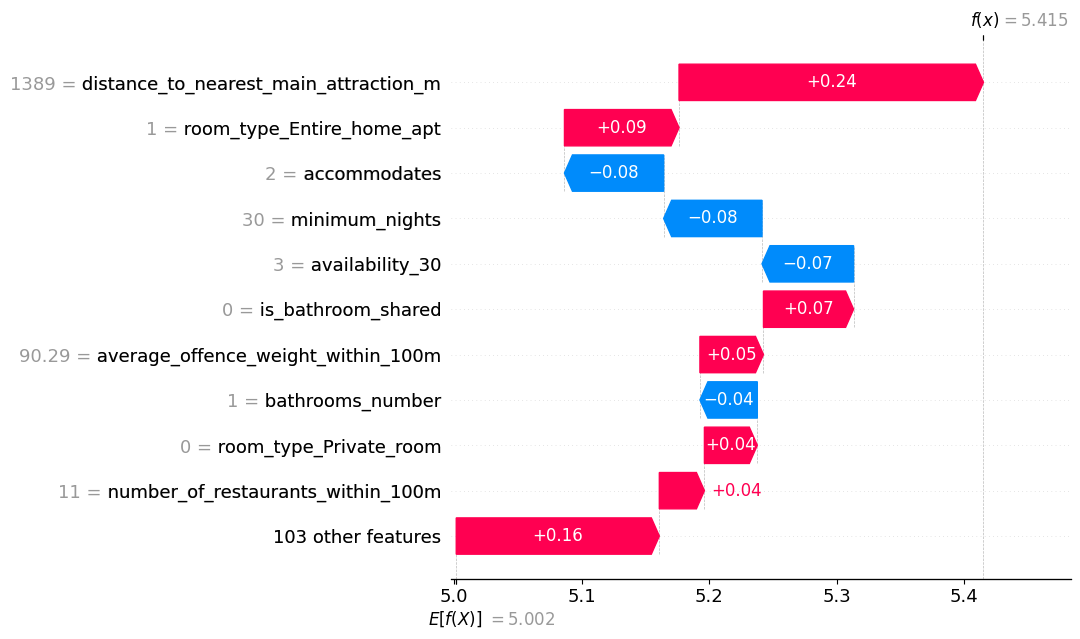

In [45]:
shap.plots.waterfall(shap_values[i_med], max_display=11, show=False)
plt.show()
plt.clf()

**Notes:**
- The biggest influence on the prediction for this observation was the `distance_to_nearest_main_attraction_m` variable.
- The influence is positive because the value of the variable for this observation is smaller than the average value of all predictions: closer to the main attraction.e 

## Global Shap values

### Bar plot

Below bar plot shows the absolute average SHAP value for each variable.

Features with higher absolute averages have a greater impact on prediction. 

However, it is worth noting that such a plot will not answer the question of whether the variable had a negative or positive impact on the prediction.

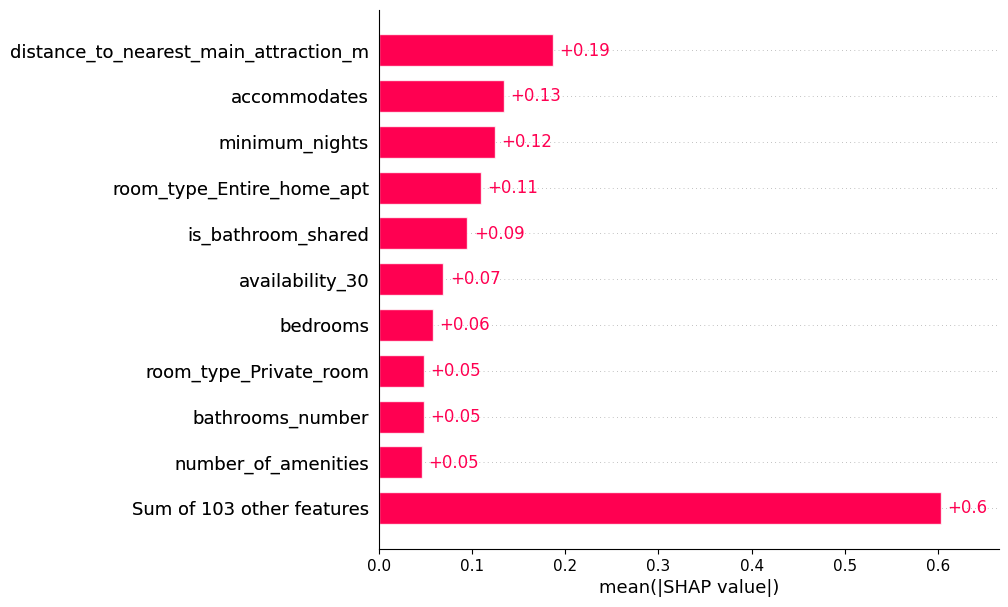

In [42]:
shap.plots.bar(shap_values, max_display=11, show=False)
plt.show()
plt.clf()

**Notes:**
- The biggest influence on the predictions overall was the `distance_to_nearest_main_attraction_m` variable.
- Sum of absolute average SHAP values for 10 most important features is 0.92 which means that they have more impact than rest of 103 features combined.oser to the main attraction.

### Beeswarn plot

Beeswarm charts are more complex than simple bar charts and show both the values of the variables and their impact (positive or negative) for each individual prediction.

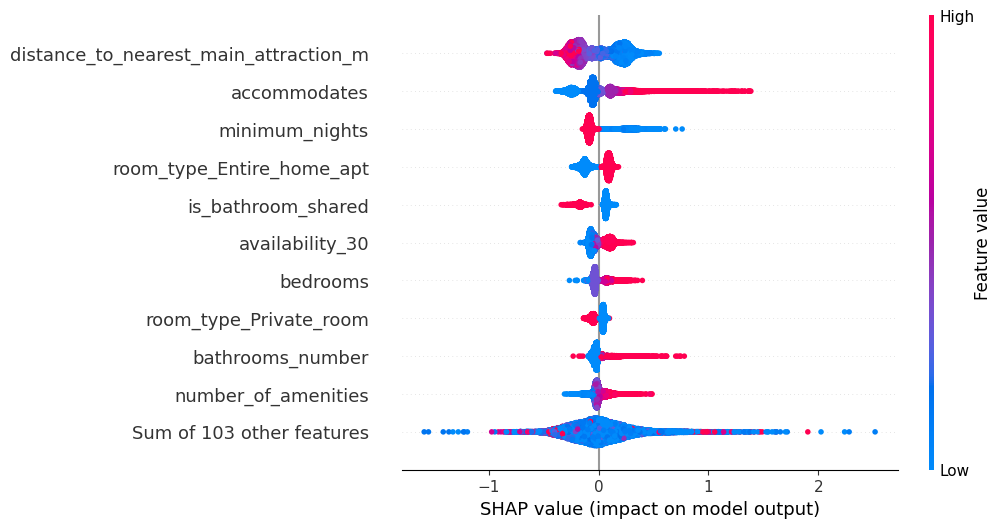

In [58]:
shap.plots.beeswarm(shap_values, max_display=11, show=False)
plt.show()
plt.clf()

**Notes:**
- The higher the distance from the main attraction, the lower the predicted price.
- The more accomodates the listing has, the higher the predicted price.
- The higher the number of bedrooms, the higher the predicted price.

# Evaluate model

In [37]:
#Base model
model = XGBRegressor(random_state=SEED, n_jobs=-1)
base_train_scores, base_validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
train_score, base_test_score, y_test_pred = evaluation(train_data[independent_features], train_data[target_feature], test_data[independent_features], test_data[target_feature], model, metric=root_mean_squared_error)

#Tuned model
model = XGBRegressor(random_state=SEED, n_jobs=-1, **best_params)
tuned_train_scores, tuned_validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
tuned_train_score, tuned_test_score, tuned_y_test_pred = evaluation(train_data[independent_features], train_data[target_feature], test_data[independent_features], test_data[target_feature], model, metric=root_mean_squared_error)

results = pd.DataFrame({'model': ['Base', 'Tuned'], f'Train {compare_metric_name}': [np.mean(base_train_scores), np.mean(tuned_train_scores)], f'Validation {compare_metric_name}': [np.mean(base_validation_scores), np.mean(tuned_validation_scores)], f'Test {compare_metric_name}': [base_test_score, tuned_test_score]})
results.style.background_gradient(cmap='Reds', axis=0)

,model,Train RMSE,Validation RMSE,Test RMSE
0,Base,0.259805,0.394160,0.394220
1,Tuned,0.165787,0.371520,0.370699


## Save model

In [38]:
test_indices = test_data.index
model_XGB = {
    "name": "XGBoost",
    "train_results": tuned_train_score,
    "test_results": tuned_test_score,
    "predictions": tuned_y_test_pred,
    "indices": test_indices
}
with open('saved_models/model_XGB.pkl', 'wb') as f:
    pickle.dump(model_XGB, f)